[View in Colaboratory](https://colab.research.google.com/github/ayshrwt/Dog-vs-Cat-Classification-Using-CNN/blob/master/Dog_Vs_Cat_Conv_Neural_Network.ipynb)

In [0]:
!pip install fastai

In [0]:
!pip install scipy==1.0.0

In [0]:
!pip install pillow==4.1.1

In [0]:
!wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/

In [5]:
!ls data/dogscats/

models	sample	test1  train  valid


In [0]:
from fastai import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH="data/dogscats/"

In [0]:
sz=224

In [15]:
!ls {PATH}

models	sample	test1  train  valid


In [13]:
!ls {PATH}valid

cats  dogs


In [0]:
files = !ls {PATH}valid/cats | head

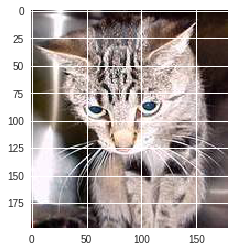

In [24]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like !

In [25]:
img.shape

(198, 179, 3)

In [32]:
img[:4, :4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [0]:
#Uncomment the below if you need to reset your precomputed activations
#!rm -rf {PATH}tmp

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 50764176.71it/s]


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


In [17]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.056998   0.02793    0.9895    
    1      0.0442     0.030788   0.991     
 12%|█▏        | 43/360 [00:01<00:12, 24.64it/s, loss=0.0432]

    2      0.056249   0.032826   0.989     



[array([0.03283]), 0.989]

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
bs=64

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [22]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.061169   0.026496   0.9905    
    1      0.060027   0.028731   0.99      



[array([0.02873]), 0.99]

In [0]:
learn.precompute=False

In [24]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.043707   0.026487   0.9905    



[array([0.02649]), 0.9905]

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [29]:
learn.fit(lr,1,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.053347   0.025482   0.9925    



[array([0.02548]), 0.9925]

In [48]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [49]:
#from here we know that cats is labeled 0 and dogs is labeled 1
data.classes

['cats', 'dogs']

In [50]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [51]:
log_preds[:10]

array([[-0.00036, -7.93258],
       [-0.00686, -4.98478],
       [-0.00037, -7.90601],
       [-0.00008, -9.38558],
       [-0.00013, -8.98295],
       [-0.00048, -7.64137],
       [-0.00005, -9.94727],
       [-0.00318, -5.75373],
       [-0.00024, -8.35353],
       [-0.00046, -7.68681]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  #from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        #pr(dog) 

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


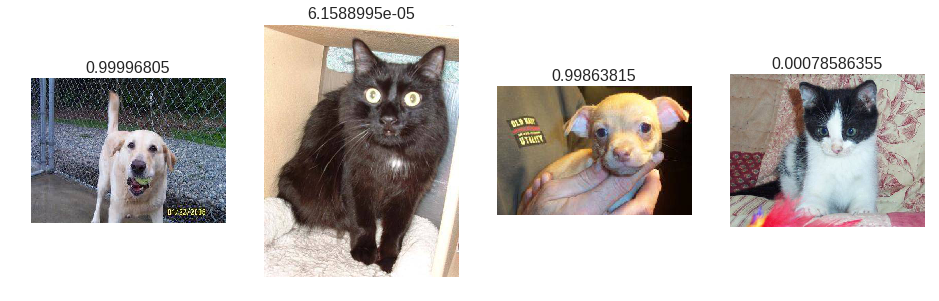

In [58]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


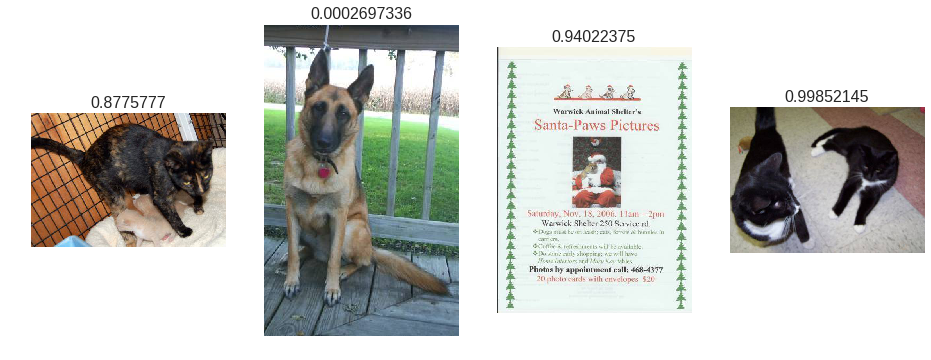

In [64]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


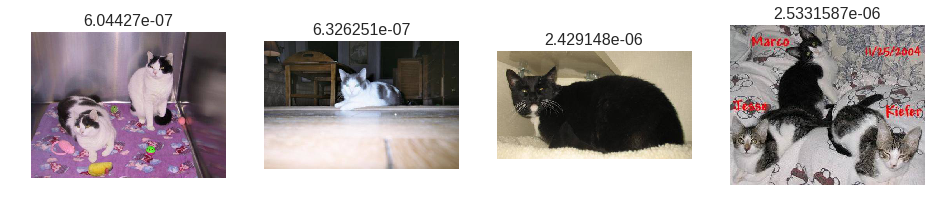

In [63]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


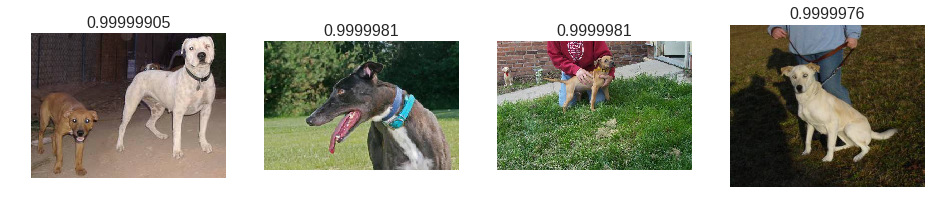

In [66]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


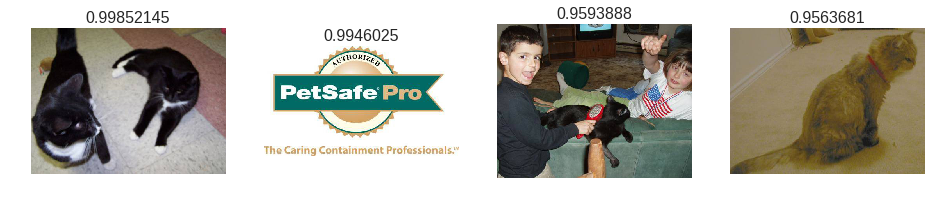

In [67]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


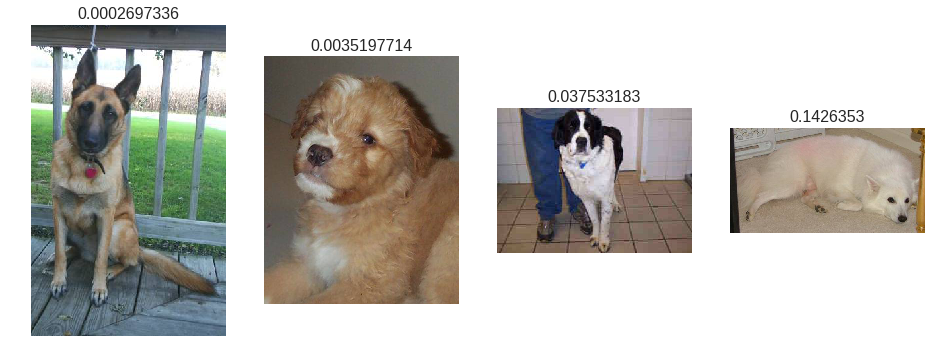

In [68]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


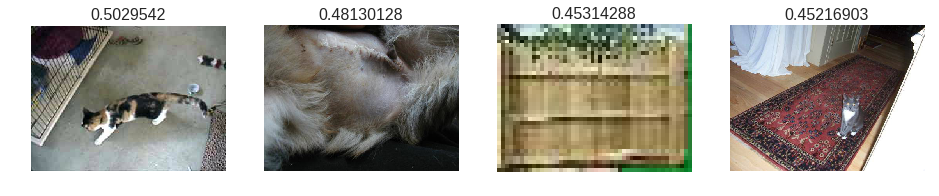

In [69]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")